In [70]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## $$
M \frac{d^2x}{dt^2} + kx = a\frac{x^3}{6}
$$

## initialization

In [529]:
M = 1 # mass
k = 1 # spring constant
a = 0.5 # constant
V1 = 0.2 # interaction strength (coupling constant)
hbar = 1
# mesh grading
start_x = -5
dx = 0.2
end_x = 5
x = np.arange(start_x,end_x,dx)
n = len(x)


## Define identity operator and transfer matrix

In [530]:
Id = sp.sparse.csr_matrix(np.eye(n)) # single particle identity operator
T = np.diag(np.ones(n-1),1) + np.diag([1],-(n-1))
T = sp.sparse.csr_matrix(T)
D1x = (-np.diag(np.ones(n),0) + np.diag(np.ones(n-1),1))/dx
D1x[n-1,0] = 1/dx
P1x = -1j*hbar*D1x
P2x = (np.matmul(P1x,P1x.conj().T) + np.matmul(P1x.conj().T,P1x))/2

## Define $h_p^1,h_p^2$ and $n_i$

In [531]:
h_1p = -(T.T+T)
#h1_p = P2x/(2*M)
empty = sp.sparse.csr_matrix((n,n))
n_1p = [None] * n
for i1 in range(0,n):
    n_1p[i1] = empty.copy()
    n_1p[i1][i1,i1] = 1

## Define harmonic potential

In [532]:
harmonic_potential = 0.5 * k * x**2
harmonic_potential = np.diag(harmonic_potential)
H = h_1p + harmonic_potential
for i1 in range(0,n) :
    H = H + V1* n_1p[i1] @ n_1p[i1]

## Define H

In [533]:
H = (sp.sparse.kron(H,Id) + sp.sparse.kron(Id,H)) / 2  

# Permutation Operator

In [534]:
index_12 = np.reshape(np.arange(1,n**2+1,1),(n,n))
index_21 = np.ravel(np.reshape(index_12.T,(-1,1)))
A = np.eye(n**2)
P12 = A[:,index_21-1] 

## Find ($\lambda$ = 1) 's of permutation operator -> Boson 

In [535]:
eigenvalues_p , eigenvectors_p = np.linalg.eigh(P12)
boson_index = eigenvalues_p == 1
transfer_matrix =  eigenvectors_p[:,boson_index]

In [536]:
H = transfer_matrix.conjugate().transpose() @ H @ transfer_matrix

In [537]:
eigenvalues, eigenvectors = np.linalg.eigh(H)

## Find eigen vector related to eigen value = 0  
### because right hand side of equation is 0

In [538]:
index = 0
for i in range(len(eigenvalues)):
    if eigenvalues[i] < 1e-10:
        index = i

In [539]:
ans = eigenvectors[:,index]

## Transfer $\psi$ into original space

In [540]:
original_psi = np.matmul(transfer_matrix,ans)

## Extract $|x>$ from $|\psi> = |x> \otimes |x>$

In [541]:
psi_matrix = original_psi.reshape(n,n)

U, S, Vt = np.linalg.svd(psi_matrix)

# Extract the first two columns of U and Vt to get the two 40x1 vectors
vector1 = U[:, 0]
vector2 = Vt[0, :]

vector1 /= np.linalg.norm(vector1)
vector2 /= np.linalg.norm(vector2)

# Print the vectors
#print("Vector 1:", vector1)
#print("Vector 2:", vector2)

## Plotting

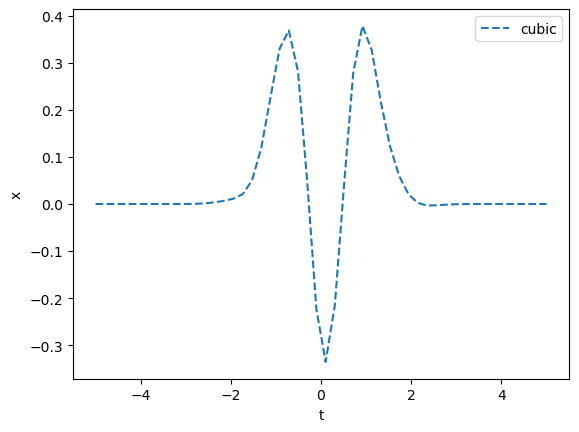

In [543]:
x = np.linspace(start_x, end_x, num=n, endpoint=True)
y = vector1
xnew = np.linspace(start_x, end_x, num=n, endpoint=True)
correlation_cubic = interp1d(x, y, kind='cubic')
plt.plot(xnew, correlation_cubic(xnew), '--', label='cubic')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()